# Re-creating [Capillary Hysteresis in Neutrally Wettable Fibrous Media: A Pore Network Study of a Fuel Cell Electrode](http://link.springer.com/10.1007/s11242-017-0973-2)
# Part B: Relative Diffusivity

## Introduction

In this notebook we will use the results from part (a) and run a Fickian diffusion simulation at different levels of saturation to generate a relative diffusivity relationship.

## Imports

In [1]:
import numpy as np
import openpnm as op
from openpnm.models import physics as pm
np.set_printoptions(precision=5)
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
ws = op.Workspace()
ws.settings['loglevel'] = 50
ws.clear()
op.io.Pickle.load_project('../../fixtures/hysteresis_paper_project');

Now retrieve the Project from the Workspace, recalling that we named is 'hysteresis_paper' in the previous example.

In [2]:
# NBVAL_IGNORE_OUTPUT
prj = ws['hysteresis_paper']
print(prj)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 network         <openpnm.network.GenericNetwork object at 0x2096dc47450>         
 geometry        <openpnm.geometry.GenericGeometry object at 0x20976c4f4f0>       
 air             <openpnm.phases.Air object at 0x209744d0130>                     
 water           <openpnm.phases.Water object at 0x20976c78270>                   
 phys_air        <openpnm.physics.Standard object at 0x20976c7ab80>               
 phys_water      <openpnm.physics.Standard object at 0x20976c83310>               
 injection       <openpnm.algorithms.MixedInvasionPercolation object at 0x209744d5130>
 withdrawal      <openpnm.algorithms.MixedInvasionPercolationCoop object at 0x20976c88630>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now that we have loaded the project we need to get handles back to all our saved objects which is done using the names given to them in part (a).

In [3]:
pn = prj.network
geom = prj.geometries('geometry')
air = prj.phases('air')
water = prj.phases('water')
phys_air = prj.physics('phys_air')
phys_water = prj.physics('phys_water')
IP_injection = prj.algorithms('injection')
IP_withdrawal = prj.algorithms('withdrawal')
pn._am

{'coo': <2853x2853 sparse matrix of type '<class 'numpy.int32'>'
 	with 20430 stored elements in COOrdinate format>,
 'lil': <2853x2853 sparse matrix of type '<class 'numpy.int32'>'
 	with 20430 stored elements in List of Lists format>}

We set the occupancy of the phases and define the multiphase conductance models. As pore network models are basically resistor networs, the phase occupancy is used to scale down the conductance of a particular phase in a particular where it is not present. The mode of the model determines how the scale factor is applied for multiphase conductance. Strict means that conductance is scaled down for the conduit comprising a half pore - throat - half pore if any of the elements is not occupied by the phase for which the physics object is applied to.

In [4]:
water["pore.occupancy"] = False
water["throat.occupancy"] = False
air["pore.occupancy"] = False
air["throat.occupancy"] = False
conduit_mode = 'strict'
phys_air.add_model(model=pm.multiphase.conduit_conductance,
                   propname='throat.conduit_diffusive_conductance',
                   throat_conductance='throat.diffusive_conductance',
                   mode=conduit_mode,
                   factor=1e-6)
phys_water.add_model(model=pm.multiphase.conduit_conductance,
                     propname='throat.conduit_diffusive_conductance',
                     throat_conductance='throat.diffusive_conductance',
                     mode=conduit_mode,
                     factor=1e-6)

Now we define a helper function to return an effective diffusivity value for flow through the network in along a particular axis. This will be called many times in a loop later.

In [5]:
def diffusivity(phase, conductance_model, axis=0):
    fd = op.algorithms.FickianDiffusion(network=pn)
    fd.setup(phase=phase, conductance=conductance_model)
    if axis == 0:
        fd.set_value_BC(pores=pn.pores('front_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('back_boundary'), values=0.5)
    elif axis == 1:
        fd.set_value_BC(pores=pn.pores('left_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('right_boundary'), values=0.5)
    else:
        fd.set_value_BC(pores=pn.pores('top_boundary'), values=1.0)
        fd.set_value_BC(pores=pn.pores('bottom_boundary'), values=0.5)
    fd.run()
    return fd.calc_effective_diffusivity()[0]

We will use the capillary pressure to set the occupancy by asking the percolation algorithm for its results. But first we want a list of pressures that will produce a range of saturations that are evenly spaced and sampled down.

In [6]:
inv_points = np.arange(0, 15025, 25)
injection_data = IP_injection.get_intrusion_data(inv_points=inv_points)
args = [0]
sats = [0]
for i in range(len(injection_data.S_tot)):
    if injection_data.S_tot[i] - sats[-1] > 0.05:
        args.append(i)
        sats.append(injection_data.S_tot[i])

Now we can loop through the pressures and collect the diffusivity information for each phase. The results are normalized by the diffusivity at full phase occupancy. As water is the invading phase for the injection algorithm, the air is normalized by the first value and water by the last.

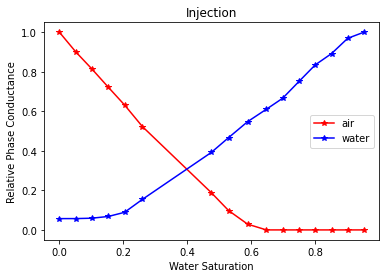

In [7]:
# NBVAL_IGNORE_OUTPUT
air.remove_model(['pore.occupancy'])
air.remove_model(['throat.occupancy'])
water.remove_model(['pore.occupancy'])
water.remove_model(['throat.occupancy'])
conds_air = []
conds_water = []
prop = 'throat.conduit_diffusive_conductance'
for Pc in injection_data.Pcap[args]:
    res = IP_injection.results(Pc)
    phys_air['throat.occupancy'] = res['throat.occupancy'] == 0.0
    phys_air['pore.occupancy'] = res['pore.occupancy'] == 0.0
    phys_water['throat.occupancy'] = res['throat.occupancy'] > 0.0
    phys_water['pore.occupancy'] = res['pore.occupancy'] > 0.0
    phys_air.regenerate_models(propnames=[prop])
    phys_water.regenerate_models(propnames=[prop])
    conds_air.append(diffusivity(air, prop))
    conds_water.append(diffusivity(water, prop))

conds_air = np.asarray(conds_air)/conds_air[0]
conds_water = np.asarray(conds_water)/conds_water[-1]
plt.figure()
plots = []
plots.append(plt.plot(sats, conds_air, 'r*-', label='air'))
plots.append(plt.plot(sats, conds_water, 'b*-', label='water'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Injection')
ax = plt.gca()
ax.legend()
isats = np.asarray(sats)
iconds_air = conds_air

Let's take a look at the data:

In [8]:
print(sats, conds_air)
print(sats, conds_water)

[0, 0.050911549523727256, 0.10173013298180678, 0.15294667324763775, 0.20359630066043602, 0.25936493362313673, 0.4749213684730929, 0.5288640172781734, 0.588297795614516, 0.6468625760439058, 0.6974279551655583, 0.7486892501503599, 0.7993623663870011, 0.8504259861912226, 0.9009302306422524, 0.9511639595332948] [1.00000e+00 9.00978e-01 8.13846e-01 7.21578e-01 6.31991e-01 5.22833e-01
 1.88012e-01 9.76540e-02 2.90092e-02 5.14082e-06 3.14752e-06 2.25989e-06
 1.25257e-06 1.05056e-06 1.00746e-06 1.00038e-06]
[0, 0.050911549523727256, 0.10173013298180678, 0.15294667324763775, 0.20359630066043602, 0.25936493362313673, 0.4749213684730929, 0.5288640172781734, 0.588297795614516, 0.6468625760439058, 0.6974279551655583, 0.7486892501503599, 0.7993623663870011, 0.8504259861912226, 0.9009302306422524, 0.9511639595332948] [0.05718 0.05733 0.05928 0.06816 0.08903 0.15451 0.39231 0.46712 0.54782
 0.61061 0.66582 0.75109 0.83473 0.89206 0.96936 1.     ]


Repeating the process for the water withdrawal follows a similar pattern but the normalizing arguments are reversed and saturation, defined as pore volume fraction occupied by water, is now 1-invading phase occupancy.

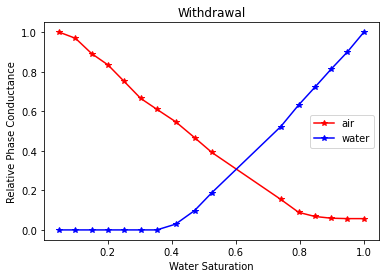

In [9]:
# NBVAL_IGNORE_OUTPUT
inv_points = np.arange(0, 15025, 25)
withdrawal_data = IP_withdrawal.get_intrusion_data(inv_points=inv_points)
args = [0]
sats = [0]
for i in range(len(withdrawal_data.S_tot)):
    if injection_data.S_tot[i] - sats[-1] > 0.05:
        args.append(i)
        sats.append(injection_data.S_tot[i])
sats = np.asarray(sats)
air.remove_model(['pore.occupancy'])
air.remove_model(['throat.occupancy'])
water.remove_model(['pore.occupancy'])
water.remove_model(['throat.occupancy'])
conds_air = []
conds_water = []
prop = 'throat.conduit_diffusive_conductance'
for Pc in injection_data.Pcap[args]:
    res = IP_injection.results(Pc)
    phys_air['throat.occupancy'] = res['throat.occupancy'] > 0.0
    phys_air['pore.occupancy'] = res['pore.occupancy'] > 0.0
    phys_water['throat.occupancy'] = res['throat.occupancy'] == 0.0
    phys_water['pore.occupancy'] = res['pore.occupancy'] == 0.0
    phys_air.regenerate_models(propnames=[prop])
    phys_water.regenerate_models(propnames=[prop])
    conds_air.append(diffusivity(air, prop))
    conds_water.append(diffusivity(water, prop))

conds_air = np.asarray(conds_air)/conds_air[-1]
conds_water = np.asarray(conds_water)/conds_water[0]
plt.figure()
plots = []
plots.append(plt.plot(1-sats, conds_air, 'r*-', label='air'))
plots.append(plt.plot(1-sats, conds_water, 'b*-', label='water'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Withdrawal')
ax = plt.gca()
ax.legend()
wsats = sats
wconds_air = conds_air

Let's take a look at the data:

In [10]:
print(1-sats, conds_air)
print(1-sats, conds_water)

[1.      0.94909 0.89827 0.84705 0.7964  0.74064 0.52508 0.47114 0.4117
 0.35314 0.30257 0.25131 0.20064 0.14957 0.09907 0.04884] [0.0571  0.05724 0.0592  0.06805 0.0889  0.15432 0.39212 0.46696 0.54764
 0.61043 0.66567 0.75099 0.83467 0.89203 0.96938 1.     ]
[1.      0.94909 0.89827 0.84705 0.7964  0.74064 0.52508 0.47114 0.4117
 0.35314 0.30257 0.25131 0.20064 0.14957 0.09907 0.04884] [1.00000e+00 9.01047e-01 8.13927e-01 7.21643e-01 6.32059e-01 5.22920e-01
 1.88205e-01 9.77726e-02 2.90554e-02 5.14038e-06 3.14779e-06 2.26017e-06
 1.25273e-06 1.05061e-06 1.00748e-06 1.00038e-06]


Now we can compare the relative air diffusivity for the two algorithms. When water is the invading phase, this can be likened to  a fuel cell operating at high current density where much water is expelled from the catalyst regions. When air is invading, the cell may be undergoing evaporation, rest or purging.

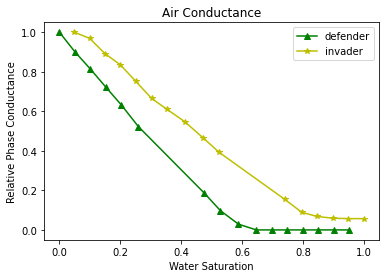

In [11]:
# NBVAL_IGNORE_OUTPUT
plt.figure()
plots = []
plots.append(plt.plot(isats, iconds_air, 'g^-', label='defender'))
plots.append(plt.plot(1-wsats, wconds_air, 'y*-', label='invader'))
plt.xlabel('Water Saturation')
plt.ylabel('Relative Phase Conductance')
plt.title('Air Conductance')
ax = plt.gca()
ax.legend();

Let's take a look at the data:

In [12]:
print(isats, iconds_air)
print(1-wsats, wconds_air)

[0.      0.05091 0.10173 0.15295 0.2036  0.25936 0.47492 0.52886 0.5883
 0.64686 0.69743 0.74869 0.79936 0.85043 0.90093 0.95116] [1.00000e+00 9.00978e-01 8.13846e-01 7.21578e-01 6.31991e-01 5.22833e-01
 1.88012e-01 9.76540e-02 2.90092e-02 5.14082e-06 3.14752e-06 2.25989e-06
 1.25257e-06 1.05056e-06 1.00746e-06 1.00038e-06]
[1.      0.94909 0.89827 0.84705 0.7964  0.74064 0.52508 0.47114 0.4117
 0.35314 0.30257 0.25131 0.20064 0.14957 0.09907 0.04884] [0.0571  0.05724 0.0592  0.06805 0.0889  0.15432 0.39212 0.46696 0.54764
 0.61043 0.66567 0.75099 0.83467 0.89203 0.96938 1.     ]


There is a clear difference in the relative diffusivity, which can be explained by the configuration of the water and the size of the pores occupied by the air. As both phases are slightly non-wetting, invasion proceeds on a largest throat first basis which tend to belong to the larger pores. Therefore the most conductive pores and throats to the defending phase are knocked out first. Hence, when air is defending, it's conductivity suffers more at lower saturations.